In [307]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [308]:
df = pd.read_csv(
    "electricity-data.csv",
    engine="python",
    on_bad_lines="skip"
)


In [309]:
## TotalConsumptionBtu units: Million MMBtu

In [310]:
df

,period,location,state,sector,fuel,generation,totalConsumptionBtu
0,2024,90,Pacific,Electric Utility,all fuels,217070.10049,1248.15759
1,2024,90,Pacific,Electric Utility,all renewables,8253.03279,32.41668
2,2024,90,Pacific,Electric Utility,biomass,419.76479,5.68953
3,2024,90,Pacific,Electric Utility,all coal products,482.76122,8.82409
4,2024,90,Pacific,Electric Utility,distillate fuel oil,1928.68539,20.62239
...,...,...,...,...,...,...,...
4872,2024,IN,Indiana,Independent Power Producers,solar photovoltaic,1121.90246,3.82793
4873,2024,IN,Indiana,Independent Power Producers,solar,1121.90246,3.82793
4874,2024,IN,Indiana,Independent Power Producers,estimated total solar photovoltaic,1121.90246,0.00000
4875,2024,IN,Indiana,Independent Power Producers,estimated total solar,1121.90246,0.00000


In [311]:
df.describe()

,period,generation,totalConsumptionBtu
count,4877.0,4877.000000,4877.000000
mean,2024.0,9402.376706,72.646323
std,0.0,35366.228086,286.999927
min,2024.0,-1392.133000,0.000000
25%,2024.0,6.299410,0.013160
50%,2024.0,121.336000,0.899330
75%,2024.0,1949.488470,18.237250
max,2024.0,614248.954660,5558.587300


In [312]:
df['location'].value_counts()

location
ENC    411
90     409
CA     385
FL     302
IL     287
ESC    287
IA     278
CT     261
GA     258
CO     252
AK     238
ID     229
AR     228
HI     212
AZ     202
DE     194
AL     188
IN     172
DC      84
Name: count, dtype: int64

In [313]:
df['sector'].value_counts()

sector
All Sectors                      598
Electric Power                   495
Electric Power Sector Non-CHP    494
Independent Power Producers      481
Electric Utility                 472
All Industrial                   393
IPP Non-CHP                      388
All Commercial                   333
Industrial CHP                   318
Commercial Non-CHP               221
IPP CHP                          214
Commercial CHP                   202
Industrial Non-CHP               184
Residential                       54
Coal Consumption                  30
Name: count, dtype: int64

In [314]:
df['state'].value_counts()

state
East North Central      411
Pacific                 409
California              385
Florida                 302
Illinois                287
East South Central      287
Iowa                    278
Connecticut             261
Georgia                 258
Colorado                252
Alaska                  238
Idaho                   229
Arkansas                228
Hawaii                  212
Arizona                 202
Delaware                194
Alabama                 188
Indiana                 172
District of Columbia     84
Name: count, dtype: int64

In [315]:
### SINCE LOCATION AND STATE IS BASICALLY THE SAME FEATURE BUT LOCATION IS ABBREVIATED, IT IS BETTER TO DROP ONE OF THE FEATURE ENTIRELY

In [316]:
df = df.drop('location',axis=1)

In [317]:
### Get dummy variables to convert non numeric features into numeric (binary) ones

In [318]:
df = pd.get_dummies(df, columns=["state"], drop_first=True, dtype=int)


In [319]:
df = pd.get_dummies(df, columns=["sector"], drop_first=True, dtype=int)


In [320]:
df = pd.get_dummies(df, columns=["fuel"], drop_first=True, dtype=int)


In [321]:
df.shape


(4877, 75)

<Axes: >

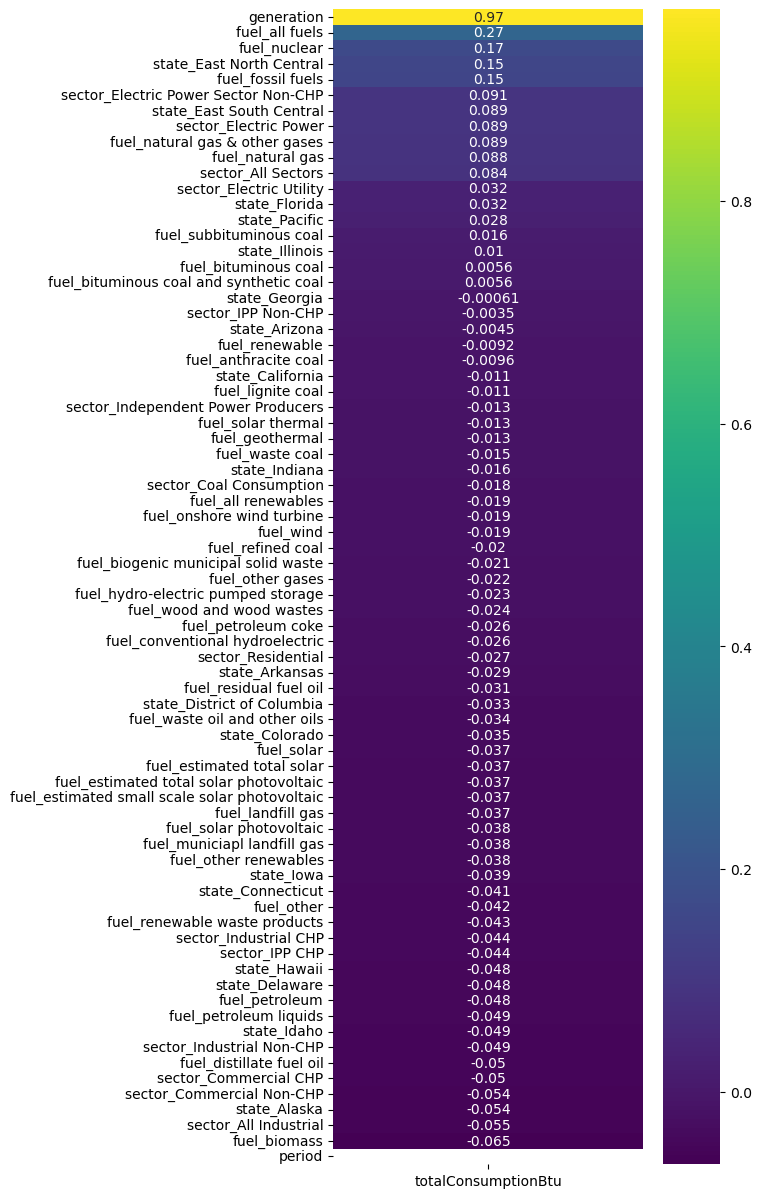

In [322]:
plt.figure(figsize=(5,15))
corr_series = (df.corr(numeric_only=True)["totalConsumptionBtu"].drop("totalConsumptionBtu").sort_values(ascending=False))

sns.heatmap(corr_series.to_frame(),cmap="viridis", annot=True)


In [323]:
### Total Consumption is highly correlated with generation feature, then it faces a steep decline across all other features, this will be taken into consideration

In [324]:
y=df['totalConsumptionBtu']
X=df.drop(['totalConsumptionBtu','period'],axis=1)

In [325]:
### With Generation Feature

In [326]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
r2_ridge_with_generation = r2_score(y_test,model.predict(X_test))
print("R²:", r2_ridge_with_generation)


R²: 0.9655065204457338


In [327]:
### Without Generation Feature

In [328]:
X_no_gen = X.drop(columns=["generation"])


In [329]:
X_train, X_test, y_train, y_test = train_test_split(X_no_gen, y, test_size=0.2, random_state=42)

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
r2_ridge_without_generation = r2_score(y_test,model.predict(X_test))
print("R²:", r2_ridge_without_generation)


R²: 0.25787501601565255


In [330]:
### Since fuel consumption (Btu) is directly related as seen in correlation heatmap and through formula as Fuel Consumption (MMBtu)=Generation (MWh)×(Heat Rate (Btu/kWh)/1000), r^2 score shoots up by alot, hence it is important to how much signal is picked up just from other features alone. 

In [331]:
### Comparison of r^2 score across various models (with/without Generation Feature): RF Regressor with Generation

In [332]:
from sklearn.ensemble import RandomForestRegressor
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)
rf = RandomForestRegressor(n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=3, max_features=1.0, bootstrap=True, n_jobs=1, random_state=42)

In [333]:
rf.fit(X_train,y_train)

RandomForestRegressor(min_samples_leaf=3, n_estimators=300, n_jobs=1,
                      random_state=42)

In [334]:
r2_rf_with_generation = r2_score(y_test,rf.predict(X_test))
print("R²:", r2_rf_with_generation)

R²: 0.968214217843971


In [335]:
### RF Regressor without Generation

In [336]:
X_train,X_test,y_train,y_test = train_test_split(X_no_gen,y,test_size=0.2,random_state=42)

In [337]:
rf = RandomForestRegressor(n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=3, max_features=1.0, bootstrap=True, n_jobs=1, random_state=42)

In [338]:
rf.fit(X_train,y_train)

RandomForestRegressor(min_samples_leaf=3, n_estimators=300, n_jobs=1,
                      random_state=42)

In [339]:
r2_rf_without_generation=r2_score(y_test,rf.predict(X_test))
print("R²:", r2_rf_without_generation)

R²: 0.3673356820031167


In [340]:
data = {
    'r2_ridge (with generation)': r2_ridge_with_generation,
    'r2_ridge (without generation)':r2_ridge_without_generation,
    'r2_rf (with generation)' : r2_rf_with_generation,
    'r2_rf (without generation)' : r2_rf_without_generation
}

In [341]:
data

{'r2_ridge (with generation)': 0.9655065204457338,
 'r2_ridge (without generation)': 0.25787501601565255,
 'r2_rf (with generation)': 0.968214217843971,
 'r2_rf (without generation)': 0.3673356820031167}

In [342]:
### Grid Search RF Regressor (With Generation)

In [343]:
from sklearn.model_selection import GridSearchCV

In [344]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [345]:
param_grid = {
    "n_estimators" : [100,200,300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", "log2"]
}

In [346]:
base_rf= RandomForestRegressor(n_estimators=100,random_state=42)

In [347]:
grid_rf=GridSearchCV(base_rf,param_grid,cv=2,scoring="r2",verbose=1)

In [348]:
grid_rf.fit(X_train,y_train)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=1)

In [349]:
best_rf = grid_rf.best_estimator_

best_rf.fit(X_train, y_train)
print("R²:", r2_score(y_test, best_rf.predict(X_test)))


R²: 0.9161241500513098


In [350]:
### Grid Search RF Regressor (Without Generation)

In [351]:
X_train,X_test,y_train,y_test=train_test_split(X_no_gen,y,test_size=0.2,random_state=42)

In [352]:
param_grid = {
    "n_estimators" : [100,200,300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", "log2"]
}

In [353]:
grid_rf=GridSearchCV(base_rf,param_grid,cv=2,scoring="r2",verbose=1)

In [354]:
grid_rf.fit(X_train,y_train)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=1)

In [355]:
best_rf = grid_rf.best_estimator_

best_rf.fit(X_train, y_train)
print("R²:", r2_score(y_test, best_rf.predict(X_test)))


R²: 0.3144023593950207


In [412]:
data


{'r2_ridge (with generation)': 0.9655065204457338,
 'r2_ridge (without generation)': 0.25787501601565255,
 'r2_rf (with generation)': 0.968214217843971,
 'r2_rf (without generation)': 0.3673356820031167}

In [418]:
results = pd.DataFrame({
    "model": ["Ridge", "Ridge", "Random Forest", "Random Forest"],
    "generation_included": [True, False, True, False],
    "r2_score": [
        r2_ridge_with_generation,
        r2_ridge_without_generation,
        r2_rf_with_generation,
        r2_rf_without_generation
    ]
})


In [420]:
results

,model,generation_included,r2_score
0,Ridge,True,0.965507
1,Ridge,False,0.257875
2,Random Forest,True,0.968214
3,Random Forest,False,0.367336
